In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib
from qiskit.test.mock import FakeAlmaden
from qiskit.ignis.verification.tomography.data import marginal_counts

In [3]:
import pulse_compiler_helper_fns

In [4]:
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
back_config = backend.configuration().to_dict()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [5]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 0.176,
                       'jq0q1': -0.0069}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0
back_config['ode_options'] = {}
back_config['qubit_list'] = [0,1]

In [6]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) 
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

In [7]:
shots = 1000

In [8]:
qobj = q.assemble(x_schedules, backend, 
                       meas_level=1, meas_return='avg', 
                       memory_slots=2,
                       shots=shots, sim_config = back_config)

In [9]:
evals, estates = backend_sim.get_dressed_energies(qobj)
evals/2/np.pi

array([0.        , 4.85720941, 4.97172909, 9.82893851])

In [10]:
# Measure Y on target
y_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

In [11]:
# Measure Z on target
z_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [12]:
shots = 10000

qobj = q.assemble(x_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
x_result = backend_sim.run(qobj).result()

qobj = q.assemble(y_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
y_result = backend_sim.run(qobj).result()

qobj = q.assemble(z_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
z_result = backend_sim.run(qobj).result()

In [18]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [19]:
x_vals_control_off = []
for i in range(41):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_off.append((x_counts.get('0', 0) / shots - 0.5) * 2)

x_vals_control_on = []
for i in range(41, 82):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_on.append((x_counts.get('0', 0) / shots - 0.5) * 2)

print(x_vals_control_off)
print(x_vals_control_on)

[-0.01959999999999995, 0.01760000000000006, 0.045600000000000085, 0.0616000000000001, 0.07919999999999994, 0.0633999999999999, 0.05380000000000007, 0.04519999999999991, 0.02320000000000011, -0.0016000000000000458, -0.03979999999999995, -0.07040000000000002, -0.0806, -0.10799999999999998, -0.12980000000000003, -0.14680000000000004, -0.15080000000000005, -0.135, -0.12780000000000002, -0.09040000000000004, -0.06620000000000004, -0.045399999999999996, -0.028200000000000003, -0.018000000000000016, -0.0010000000000000009, 0.024799999999999933, 0.023600000000000065, -0.00039999999999995595, -0.027599999999999958, -0.009199999999999986, -0.041200000000000014, -0.0746, -0.09960000000000002, -0.12160000000000004, -0.123, -0.12139999999999995, -0.10860000000000003, -0.08699999999999997, -0.08440000000000003, -0.05379999999999996, -0.025800000000000045]
[0.0023999999999999577, -0.015199999999999991, -0.04479999999999995, -0.06000000000000005, -0.09219999999999995, -0.08479999999999999, -0.10260000

In [20]:
y_vals_control_off = []
for i in range(41):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_off.append((y_counts.get('0', 0) / shots - 0.5) * 2)

y_vals_control_on = []
for i in range(41, 82):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_on.append((y_counts.get('0', 0) / shots - 0.5) * 2)

print(y_vals_control_off)
print(y_vals_control_on)

[0.004999999999999893, -0.08340000000000003, -0.17459999999999998, -0.23839999999999995, -0.31679999999999997, -0.3808, -0.482, -0.5254, -0.6033999999999999, -0.6562, -0.7014, -0.7598, -0.7946, -0.848, -0.8852, -0.9164, -0.9446, -0.9626, -0.981, -0.9898, -0.9982, -0.996, -0.9902, -0.9746, -0.9518, -0.9186, -0.889, -0.8642, -0.819, -0.7654, -0.7034, -0.6496, -0.5813999999999999, -0.521, -0.4646, -0.3862, -0.31120000000000003, -0.23740000000000006, -0.15600000000000003, -0.07999999999999996, 0.005800000000000027]
[-0.0048000000000000265, 0.07679999999999998, 0.18179999999999996, 0.258, 0.30000000000000004, 0.3824000000000001, 0.46120000000000005, 0.5434000000000001, 0.5878000000000001, 0.6654, 0.7165999999999999, 0.7672000000000001, 0.812, 0.8566, 0.8957999999999999, 0.9328000000000001, 0.9548000000000001, 0.9742, 0.9876, 0.9956, 0.9974000000000001, 0.994, 0.9867999999999999, 0.9683999999999999, 0.95, 0.9204000000000001, 0.8928, 0.8500000000000001, 0.8056000000000001, 0.7547999999999999,

In [21]:
z_vals_control_off = []
for i in range(41):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_off.append((z_counts.get('0', 0) / shots - 0.5) * 2)

z_vals_control_on = []
for i in range(41, 82):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_on.append((z_counts.get('0', 0) / shots - 0.5) * 2)

print(z_vals_control_off)
print(z_vals_control_on)

[1.0, 0.9967999999999999, 0.986, 0.9621999999999999, 0.937, 0.9179999999999999, 0.8854, 0.8582000000000001, 0.7969999999999999, 0.7647999999999999, 0.6943999999999999, 0.6414, 0.5884, 0.5138, 0.44520000000000004, 0.3819999999999999, 0.32200000000000006, 0.23459999999999992, 0.15860000000000007, 0.06879999999999997, 0.00019999999999997797, -0.08379999999999999, -0.17079999999999995, -0.24319999999999997, -0.3104, -0.3862, -0.44199999999999995, -0.525, -0.5800000000000001, -0.6492, -0.7083999999999999, -0.7662, -0.8, -0.8496, -0.8868, -0.9144, -0.9462, -0.9704, -0.9858, -0.9968, -0.9998]
[1.0, 0.9956, 0.9872000000000001, 0.9718, 0.9505999999999999, 0.9184000000000001, 0.8844000000000001, 0.8395999999999999, 0.8033999999999999, 0.7502, 0.702, 0.6661999999999999, 0.5738000000000001, 0.51, 0.4628000000000001, 0.3972, 0.31820000000000004, 0.23140000000000005, 0.14100000000000001, 0.07499999999999996, 0.011200000000000099, -0.09099999999999997, -0.14780000000000004, -0.23399999999999999, -0.3

In [16]:
#  x_vals_control_off =
#  x_vals_control_on =
#  y_vals_control_off =
#  y_vals_control_on =
#  z_vals_control_off =
#  z_vals_control_on =

In [22]:
thetas = np.linspace(0, 180, 41, endpoint=True)
dense_thetas = np.linspace(0, 180, 101, endpoint=True)

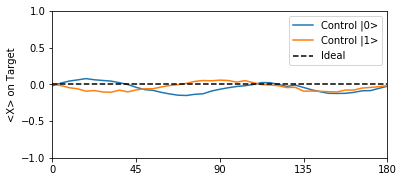

In [23]:
fig, ax = plt.subplots(figsize=(6, 2.7))
plt.plot(thetas, x_vals_control_off, label='Control |0>')
plt.plot(thetas, x_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, [0] * 101, label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([0, 45, 90, 135, 180])
plt.legend()
plt.ylabel('<X> on Target')
plt.savefig('Figures/CR_X_SIMULATED.svg')

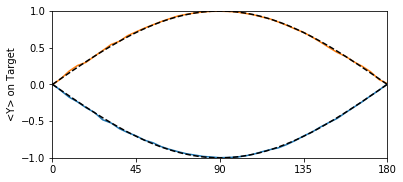

In [24]:
fig, ax = plt.subplots(figsize=(6, 2.7))
plt.plot(thetas, y_vals_control_off, label='Control |0>')
plt.plot(thetas, y_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.sin(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.plot(dense_thetas, -np.sin(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.ylabel('<Y> on Target')
plt.yticks([-1, -.5, 0, .5, 1])
_=plt.xticks([0, 45, 90, 135, 180])
plt.savefig('Figures/CR_Y_SIMULATED.svg')

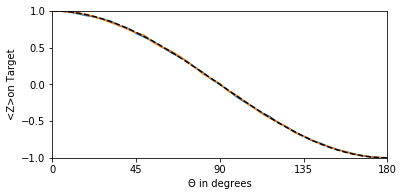

In [25]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(thetas, z_vals_control_off, label='Control |0>')
plt.plot(thetas, z_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.cos(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.ylabel('<Z>on Target')
plt.yticks([-1, -.5, 0, .5, 1])
_=plt.xticks([0, 45, 90, 135, 180])
plt.xlabel('Θ in degrees')
plt.gcf().subplots_adjust(bottom=.2)
plt.savefig('Figures/CR_Z_SIMULATED.svg')